In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [2]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe

df = pd.read_csv("E:\\PROJECTS\\MLWARE\\dataset\\train\\train_landmarks.csv", dtype = dt)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 129.31it/s]


<Figure size 432x288 with 0 Axes>

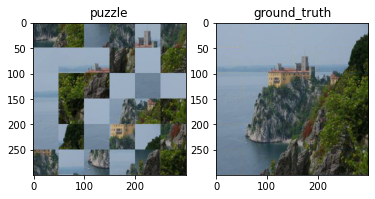

In [3]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("E:\\PROJECTS\\MLWARE\\dataset\\train\\landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("E:\\PROJECTS\\MLWARE\\dataset\\train\\landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

train_img = load_images(train_df)
val_img = load_images(val_df)




In [4]:

print(train_img.shape)
print(val_img.shape)
#2400 puzzles, 36 pieces, each piece is a 50x50x3 image

(2400, 36, 50, 50, 3)
(600, 36, 50, 50, 3)


In [5]:
train_img

array([[[[[ 10,   9,  15],
          [ 10,   9,  15],
          [ 11,  10,  16],
          ...,
          [ 96,  94,  82],
          [113, 111, 116],
          [121, 119, 124]],

         [[ 11,  10,  16],
          [ 11,  10,  16],
          [ 11,  10,  16],
          ...,
          [ 99,  97,  85],
          [106, 104, 109],
          [118, 116, 121]],

         [[ 11,  10,  16],
          [ 11,  10,  16],
          [ 11,  10,  16],
          ...,
          [114, 112, 100],
          [105, 103, 106],
          [118, 116, 119]],

         ...,

         [[130, 121, 116],
          [146, 137, 132],
          [155, 146, 141],
          ...,
          [115, 101, 100],
          [118, 104, 101],
          [129, 118, 114]],

         [[129, 125, 124],
          [162, 158, 157],
          [157, 153, 152],
          ...,
          [114, 127, 146],
          [139, 133, 193],
          [131, 128, 157]],

         [[124, 124, 124],
          [126, 126, 126],
          [129, 129, 131],
         

In [6]:
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

train_labels = load_labels(train_df)
val_labels = load_labels(val_df)
print(train_labels.shape)
print(val_labels.shape)


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 944.45it/s]

(2400, 36, 36)
(600, 36, 36)


In [7]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow import keras

In [8]:
inp = tf.keras.layers.Input(shape=(36,50,50,3))

In [9]:
#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(16, (5,5), strides=5)
conv2 = tf.keras.layers.Conv2D(32, (5,5), strides=5)
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = conv2(x)
    x = flat(x)
    x = dense1(x)
    mid.append(x)
x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability


model = tf.keras.Model(inputs=inp, outputs=x)
adam = keras.optimizers.Adam(lr=.001)
model.compile(optimizer=adam, loss="categorical_crossentropy",metrics=['accuracy'])

tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


C:\Users\asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=32, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=50)
model.summary()

Epoch 1/50
75/75 [==============================] - 7s 97ms/step - loss: 3.5458 - accuracy: 0.0525 - val_loss: 3.5663 - val_accuracy: 0.0495
Epoch 2/50
75/75 [==============================] - 8s 102ms/step - loss: 3.5281 - accuracy: 0.0536 - val_loss: 3.5654 - val_accuracy: 0.0524
Epoch 3/50
75/75 [==============================] - 7s 100ms/step - loss: 3.5080 - accuracy: 0.0538 - val_loss: 3.5484 - val_accuracy: 0.0498
Epoch 4/50
75/75 [==============================] - 8s 101ms/step - loss: 3.4966 - accuracy: 0.0555 - val_loss: 3.5285 - val_accuracy: 0.0516
Epoch 5/50
75/75 [==============================] - 8s 108ms/step - loss: 3.4770 - accuracy: 0.0557 - val_loss: 3.5111 - val_accuracy: 0.0525
Epoch 6/50
75/75 [==============================] - 8s 104ms/step - loss: 3.4700 - accuracy: 0.0569 - val_loss: 3.5063 - val_accuracy: 0.0530
Epoch 7/50
75/75 [==============================] - 7s 98ms/step - loss: 3.4557 - accuracy: 0.0581 - val_loss: 3.4952 - val_accuracy: 0.0527
Epoch 8/

                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__oper

 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_30 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_31 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_32 (S  (None, 50, 50, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
          

                                                                  'tf.__operators__.getitem_32[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_33[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_34[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_35[0][
                                                                 0]']                             
                                                                                                  
 conv2d_1 (Conv2D)              (None, 2, 2, 32)     12832       ['conv2d[0][0]',                 
          

 dense (Dense)                  (None, 36)           4644        ['flatten[0][0]',                
                                                                  'flatten[1][0]',                
                                                                  'flatten[2][0]',                
                                                                  'flatten[3][0]',                
                                                                  'flatten[4][0]',                
                                                                  'flatten[5][0]',                
                                                                  'flatten[6][0]',                
                                                                  'flatten[7][0]',                
                                                                  'flatten[8][0]',                
                                                                  'flatten[9][0]',                
          

In [14]:
import os

image_dir = "landmarks"  # directory containing images

# get a list of file names in the directory
file_names = os.listdir(image_dir)

# filter the list to include only image file names
image_names = [name for name in file_names if name.lower().endswith((".jpg", ".jpeg", ".png"))]


In [12]:
model.evaluate(train_img,train_labels)

75/75 [==============================] - 3s 40ms/step - loss: 3.3247 - accuracy: 0.0796


[3.3247480392456055, 0.07959491014480591]

In [13]:
model.evaluate(val_img,val_labels)

19/19 [==============================] - 1s 35ms/step - loss: 3.4331 - accuracy: 0.0594


[3.4330899715423584, 0.0593518503010273]

In [15]:
def loadtest_images(image_paths):
    ret = []
    for img_path in tqdm(image_paths):
        pieces = []
        img_name = os.path.basename(img_path)
        img = Image.open("landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [16]:
q=loadtest_images(image_names)

100%|█████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:03<00:00, 336.28it/s]


In [17]:
pred = model.predict(q)
pred = np.argmax(pred, axis=-1)
print(pred.shape)
print(pred)

35/35 [==============================] - 2s 33ms/step
(1096, 36)
[[23 34 28 ...  9  5 13]
 [ 0 32 15 ... 14  7  9]
 [15  9  1 ... 35 34  9]
 ...
 [24 21  9 ... 13  3 22]
 [23 35  2 ... 32  1 14]
 [ 7 35 10 ...  0 21  5]]


In [18]:
pred.shape

(1096, 36)

In [19]:
len(image_names)
import pandas as pd

# Example list of image names

# Create a DataFrame with a single "image" column
image1_df = pd.DataFrame({"image": image_names})

# Print the resulting DataFrame
print(image1_df)


               image
0     06Iw2tNw5F.jpg
1     0bfVar8Wvr.jpg
2     0cQnWlkvnU.jpg
3     0f7hkEcB6P.jpg
4     0fAyDoP6MO.jpg
...              ...
1091  ZvPT7U2d8t.jpg
1092  zWvXAlyr58.jpg
1093  ZxyuoYKkWo.jpg
1094  ZyGLUkWzNC.jpg
1095  ZyKX2wA0C7.jpg

[1096 rows x 1 columns]


In [20]:
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(image1_df["image"])
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [21]:
out

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,06Iw2tNw5F.jpg,35,54,44,02,43,05,51,35,13,...,21,54,21,51,13,54,34,13,05,21
1,0bfVar8Wvr.jpg,00,52,23,22,01,22,13,02,42,...,21,41,05,40,13,30,13,22,11,13
2,0cQnWlkvnU.jpg,23,13,01,14,12,43,02,51,53,...,50,55,52,32,03,43,14,55,54,13
3,0f7hkEcB6P.jpg,13,34,32,23,22,33,50,11,23,...,23,31,32,22,22,23,31,32,13,43
4,0fAyDoP6MO.jpg,00,23,05,03,35,55,32,01,00,...,23,11,33,02,35,21,24,00,45,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,ZvPT7U2d8t.jpg,03,11,01,00,22,15,13,23,13,...,03,12,13,00,00,03,03,13,13,32
1092,zWvXAlyr58.jpg,01,01,01,15,01,24,03,01,21,...,00,00,01,01,03,00,43,01,00,50
1093,ZxyuoYKkWo.jpg,40,33,13,03,24,05,34,35,51,...,03,34,43,55,01,03,03,21,03,34
1094,ZyGLUkWzNC.jpg,35,55,02,50,50,01,54,00,51,...,44,50,01,55,21,54,00,52,01,22


In [22]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [23]:
submission = prediction_to_submission(out)

In [24]:
submission

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,06Iw2tNw5F.jpg,3,5,4,0,4,0,5,3,1,...,1,4,1,1,3,4,4,3,5,1
1,0bfVar8Wvr.jpg,0,5,2,2,0,2,1,0,4,...,1,1,5,0,3,0,3,2,1,3
2,0cQnWlkvnU.jpg,2,1,0,1,1,4,0,5,5,...,0,5,2,2,3,3,4,5,4,3
3,0f7hkEcB6P.jpg,1,3,3,2,2,3,5,1,2,...,3,1,2,2,2,3,1,2,3,3
4,0fAyDoP6MO.jpg,0,2,0,0,3,5,3,0,0,...,3,1,3,2,5,1,4,0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,ZvPT7U2d8t.jpg,0,1,0,0,2,1,1,2,1,...,3,2,3,0,0,3,3,3,3,2
1092,zWvXAlyr58.jpg,0,0,0,1,0,2,0,0,2,...,0,0,1,1,3,0,3,1,0,0
1093,ZxyuoYKkWo.jpg,4,3,1,0,2,0,3,3,5,...,3,4,3,5,1,3,3,1,3,4
1094,ZyGLUkWzNC.jpg,3,5,0,5,5,0,5,0,5,...,4,0,1,5,1,4,0,2,1,2


In [25]:
import pandas as pd

# assume that 'out' is a variable that contains the prediction output
submission = prediction_to_submission(out) 

file_path = "landmarksub6.csv"  # replace with the path and file name where you want to save the CSV file

# convert the DataFrame to a CSV format
csv_content = submission.to_csv(index=False)

# write the CSV content to a file
with open(file_path, "w") as f:
    f.write(csv_content)

print("CSV file downloaded successfully!")


CSV file downloaded successfully!


In [26]:
import pandas as pd

# Read in CSV file
df = pd.read_csv("landmarksub6.csv")

# Drop rows with missing values
df = df.dropna()

# Print resulting DataFrame
print(df)

               image  r00  r01  r02  r03  r04  r05  r10  r11  r12  ...  c42  \
0     06Iw2tNw5F.jpg    3    5    4    0    4    0    5    3    1  ...    1   
1     0bfVar8Wvr.jpg    0    5    2    2    0    2    1    0    4  ...    1   
2     0cQnWlkvnU.jpg    2    1    0    1    1    4    0    5    5  ...    0   
3     0f7hkEcB6P.jpg    1    3    3    2    2    3    5    1    2  ...    3   
4     0fAyDoP6MO.jpg    0    2    0    0    3    5    3    0    0  ...    3   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1091  ZvPT7U2d8t.jpg    0    1    0    0    2    1    1    2    1  ...    3   
1092  zWvXAlyr58.jpg    0    0    0    1    0    2    0    0    2  ...    0   
1093  ZxyuoYKkWo.jpg    4    3    1    0    2    0    3    3    5  ...    3   
1094  ZyGLUkWzNC.jpg    3    5    0    5    5    0    5    0    5  ...    4   
1095  ZyKX2wA0C7.jpg    1    5    1    3    3    5    3    1    0  ...    2   

      c43  c44  c45  c50  c51  c52  c53  c54  c55  

In [27]:
df.to_csv("landmark_final_submssion5.csv", index=False)

# Print confirmation message
print("CSV file saved successfully.")

CSV file saved successfully.
